## EE5175: Image Signal Processing
## Lab-6

### Shape from focus

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.io import *
from skimage.io import imsave,imread 
import matplotlib as mpl
import matplotlib.cm as cm

In [45]:
# read the stack.mat file
mat_file = loadmat('stack.mat')
# get the numframes variables
num_frames = int(mat_file['numframes'])
frames = {}
# store the images in a dictionary for easier access later
for key in mat_file.keys():
    if key[:5] == 'frame':
        frames[int(key[5:])] = mat_file[key]
# delta d as mentioned in the assignment PDF
delta_d = 50.5

In [17]:
def zero_pad_image(img, padding_size):
    x, y = np.shape(img)
    padded_image = np.zeros((x+2*padding_size, y+2*padding_size))
    padded_image[padding_size:-padding_size, padding_size:-padding_size] = img
    return padded_image

In [18]:
def conv_2D(image, kernel):
    # get the shape of the image
    x, y = np.shape(image)
    # get the shape of the kernel
    # assumed that the kernel is a square matrix
    w = len(kernel)
    d = w//2
    # if the kernel is a single value, simply multiply and return
    if d == 0:
        filtered_image = kernel*image
    else:
#         elif conv_type == 'same':
            # zero pad so that the output is of the same size
        padded_image = zero_pad_image(image, d)
        filtered_image = np.zeros((x, y))
        for i in range(d, x+d):
            for j in range(d, x+d):
                # extract image patch
                patch = padded_image[i-d:i+d+1, j-d:j+d+1]
                # multiply image patch with the kernel, sum and store
                filtered_image[i-d, j-d] = np.sum(patch*kernel)
    return filtered_image

In [47]:
def modified_laplacian(image, pad_size):
    ly = np.array([[0,  1, 0], 
               [0, -2, 0], 
               [0,  1, 0]])
    lx = np.array([[0,  0, 0], 
               [1, -2, 1], 
               [0,  0, 0]])
    padded_image = image
    # get the 2D double derivatives
    image_xx = conv_2D(padded_image, lx)
    image_yy = conv_2D(padded_image, ly)
    # sum their absolute values
    ## ML = |I_xx|+|I_yy|
    return np.abs(image_xx)+np.abs(image_yy)

In [48]:
def sum_modified_laplacian(image, q):
    # get the kernel to sum over a window of size k*k
    # where k is (2q+1)
    summer = np.ones((2*q+1,2*q+1))
    modified_laplacian_image = modified_laplacian(image, q+1)
    if q == 0:
        return modified_laplacian_image
    else:
        # else sum  over modified laplacian values over a window of size k*k
        return conv_2D(modified_laplacian_image, summer)

In [49]:
def sharpened_image(max_shaprness_frames, frames_dictionary):
    x, y = np.shape(max_shaprness_frames)
    sharp_image = np.zeros((x, y))
    for i in range(x):
        for j in range(y):
            # get the image frame at which the maximum focus score is obtained
            frame = max_shaprness_frames[i, j]+1
            sharp_image[i, j] = frames_dictionary[frame][i, j]
    return sharp_image

In [60]:
from mpl_toolkits import mplot3d
def plotter_3D(q):
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(projection='3d')
    x, y = 115,115
    X, Y = np.meshgrid(np.arange(x)+1, np.arange(y)+1)
    surf = ax.plot_surface(
        X, Y, depths[q], cmap='jet', linewidth=0, antialiased=False)

    plt.title("For q=%d"%q)
    fig.colorbar(surf)
    plt.show()

In [46]:
sml_vals = {}
depths = {}
max_shaprness_frames = {}
q_vals = [0, 1, 2]
x, y = np.shape(frames[1])
for q in q_vals:
    # iterate through each q value
    stacked = np.zeros((x, y, num_frames))
    print(f"calculating sml for q = {q}")
    for i in range(num_frames):
        # make a stack comprising of the SML values for each frame
        stacked[:, :, i] = sum_modified_laplacian(frames[
            i+1], q)
    # store the sml stacks in a dictionary
    sml_vals[q] = stacked
    # get the pixelwise frame index with the maximum sharpness scores
    max_shaprness_frames[q] = np.argmax(stacked, axis=2)
    # calculate depth from the frame index
    depths[q] = max_shaprness_frames[q]*delta_d
sharp_images = {}
for q in q_vals:
    # generate the sharp images and store them in a dictionary
    sharp_images[q] = sharpened_image(max_shaprness_frames[q], frames)

calculating sml for q = 0
calculating sml for q = 1
calculating sml for q = 2


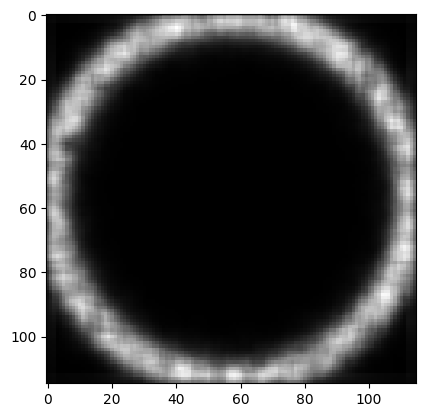

In [32]:
plt.imshow(stacked[:,:,5],'gray')

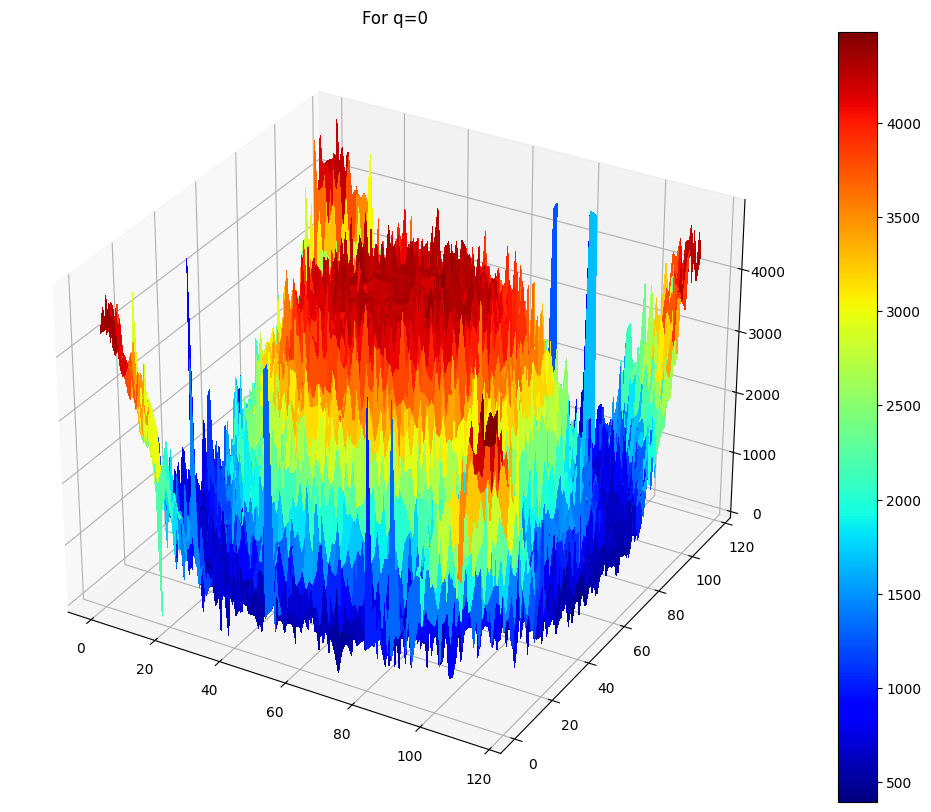

In [61]:
plotter_3D(0)

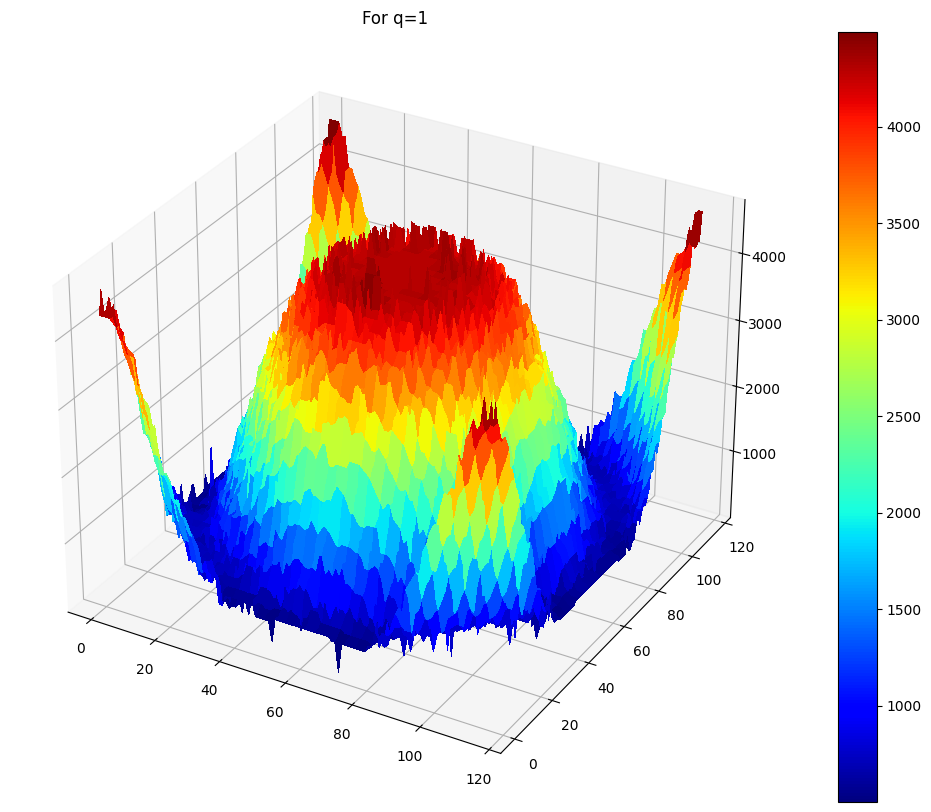

In [62]:
plotter_3D(1)

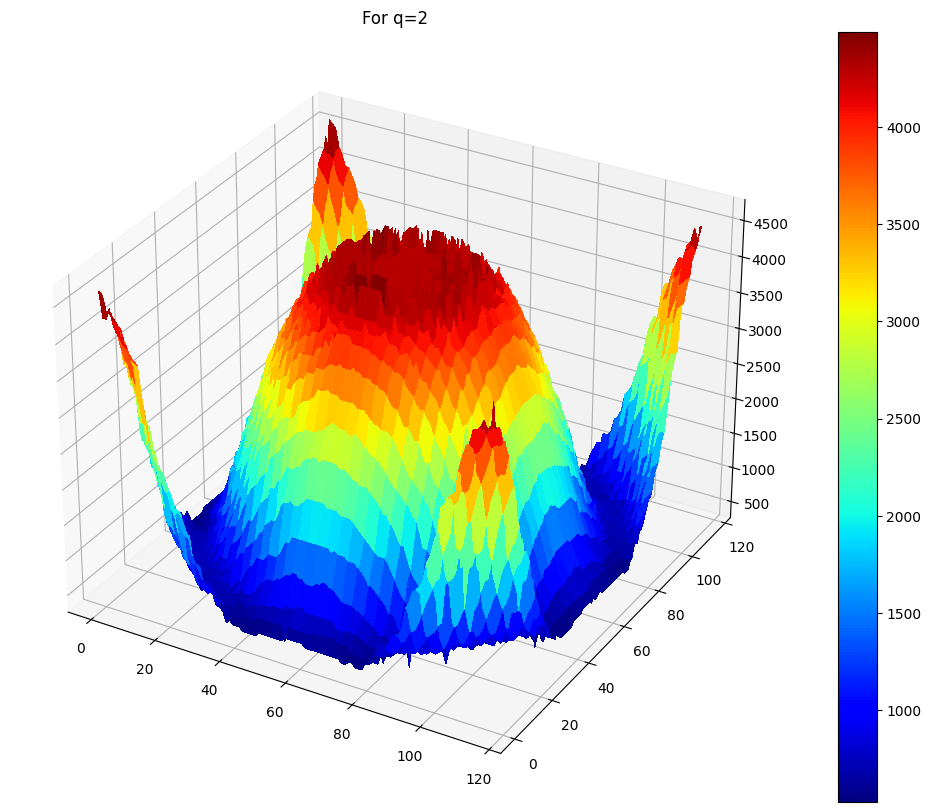

In [63]:
plotter_3D(2)

### Observations
*The following observations can be made.

* There is little to no perceptible difference in the sharp image estimates obtained using the different values of  𝑞 ..
* The depth estimates are however noticeably different. As  𝑞 increases, we get smoother estimates.
* The sharp image estimates look quite good as the images had a lot of texture. In case we had images with large flat regions, however, we would struggle.
